# Create Uniref df

In [1]:
# Autorelaod
%load_ext autoreload
%autoreload 2

import os
import pandas as pd

os.chdir("/home/gdallagl/myworkdir/ESMSec")
print(f"Working directory successfully changed to: {os.getcwd()}")

import utils.my_functions as mf
import utils.dataset_functions as dataf

config_file="/home/gdallagl/myworkdir/ESMSec/config/config.yaml"
config = mf.load_config(config_file)

mf.set_all_seeds(config["random_seed"])

Working directory successfully changed to: /home/gdallagl/myworkdir/ESMSec
Seeds set successfully to 42 for random, numpy, and PyTorch (if used).


In [2]:
# Create list of reviewed proteins
proteome_uniprot = pd.read_csv(config["data_paths"]["human_proteome_uniprot"])
ALLOWED_PROTEINS = proteome_uniprot.Entry.to_list()
ALLOWED_GENES = proteome_uniprot["Gene Names (primary)"].to_list()

print(len(ALLOWED_PROTEINS))
print(len(ALLOWED_GENES))

20210
20210


In [3]:
# Read uniport ID mapping
uniprot_id_mapping_df = pd.read_csv(
    config["data_paths"]["uniprot_mapping_id"], 
    sep='\t', 
    header=None, 
    names=['UniProtKB_Accession', 'ID_Type', 'External_ID']
)
#print(uniprot_id_mapping_df.ID_Type.unique())
uniprot_id_mapping_df.head(2)

,UniProtKB_Accession,ID_Type,External_ID
0,P31946,UniProtKB-ID,1433B_HUMAN
1,P31946,Gene_Name,YWHAB


In [4]:
# select protein and gene IDs
protein2uniref = uniprot_id_mapping_df[uniprot_id_mapping_df.ID_Type == "UniRef50"].copy()
display(protein2uniref.head(5))
display(protein2uniref.shape)

# Select only allowed proteins
    # ATTENTION: we lose some prots
protein2uniref = protein2uniref[protein2uniref.UniProtKB_Accession.isin(ALLOWED_PROTEINS)]
display(protein2uniref.head(5))
display(protein2uniref.shape)

# Map genes (and other infos)
uniref_df = pd.merge(how="inner", left=protein2uniref, right=proteome_uniprot, left_on="UniProtKB_Accession", right_on="Entry")
# rename
uniref_df = uniref_df.rename(columns={"UniProtKB_Accession": "protein", "Gene Names (primary)": "gene", "External_ID": "UniRef50_Cluster"})[["protein", "gene", "UniRef50_Cluster"]]

display(uniref_df.head(5))
display(uniref_df.shape)


,UniProtKB_Accession,ID_Type,External_ID
13,P31946,UniRef50,UniRef50_P31946
131,P62258,UniRef50,UniRef50_P62258
273,Q04917,UniRef50,UniRef50_Q04917
377,P61981,UniRef50,UniRef50_P61981
541,P31947,UniRef50,UniRef50_P31947


(204778, 3)

,UniProtKB_Accession,ID_Type,External_ID
13,P31946,UniRef50,UniRef50_P31946
131,P62258,UniRef50,UniRef50_P62258
273,Q04917,UniRef50,UniRef50_Q04917
377,P61981,UniRef50,UniRef50_P61981
541,P31947,UniRef50,UniRef50_P31947


(20207, 3)

,protein,gene,UniRef50_Cluster
0,P31946,YWHAB,UniRef50_P31946
1,P62258,YWHAE,UniRef50_P62258
2,Q04917,YWHAH,UniRef50_Q04917
3,P61981,YWHAG,UniRef50_P61981
4,P31947,SFN,UniRef50_P31947


(20207, 3)

In [5]:
# check for duplicates
print("number duplciated proteins: ", uniref_df.protein.duplicated().sum()) # no protesin mapped to multiple genes
print("number duplciated genes: ", uniref_df.gene.duplicated().sum())

duplicated_proteins = uniref_df[uniref_df["protein"].duplicated(keep=False)].sort_values("protein", ascending=False)
duplicated_genes = uniref_df[uniref_df["gene"].duplicated(keep=False)].sort_values("gene", ascending=False)

display(duplicated_proteins)
display(duplicated_genes)


number duplciated proteins:  0
number duplciated genes:  0


,protein,gene,UniRef50_Cluster


,protein,gene,UniRef50_Cluster


# Create Uniref Clusters

,UniRef50_Cluster,protein,gene,n_proteins,n_genes
11082,UniRef50_Q86YD7,"[Q86YD7, Q658T7, A0A8V8TPE2, A8MXJ8, A6NKC0, A...","[FAM90A1, FAM90A2P, FAM90A3, FAM90A5, FAM90A7,...",22,22
9859,UniRef50_Q6R6M4,"[Q7RTZ2, Q6R6M4, A6NCW0, A6NCW7, A8MUK1, P0C7H...","[USP17L1, USP17L2, USP17L3, USP17L4, USP17L5, ...",19,19
7014,UniRef50_Q13066,"[A6NGK3, Q4V321, Q6NT46, Q13066, Q4V326, P0DTW...","[GAGE10, GAGE13, GAGE2A, GAGE2B, GAGE2E, GAGE1...",17,17
18756,UniRef50_Q9Y5E9,"[Q9Y5E7, Q9Y5E6, Q9Y5E5, Q9Y5E2, Q9UN66, Q9Y5E...","[PCDHB2, PCDHB3, PCDHB4, PCDHB7, PCDHB8, PCDHB...",13,13
9118,UniRef50_Q5VXH4,"[O60813, O95522, P0DUQ1, Q5VT98, A6NGN4, H0Y7S...","[PRAMEF11, PRAMEF12, PRAMEF15, PRAMEF20, PRAME...",13,13
...,...,...,...,...,...
6532,UniRef50_Q01973,[Q01973],[ROR1],1,1
6531,UniRef50_Q01970,[Q01970],[PLCB3],1,1
6530,UniRef50_Q01968,[Q01968],[OCRL],1,1
6529,UniRef50_Q01959,[Q01959],[SLC6A3],1,1


<Axes: xlabel='n_proteins', ylabel='Number of Cluster with ...'>

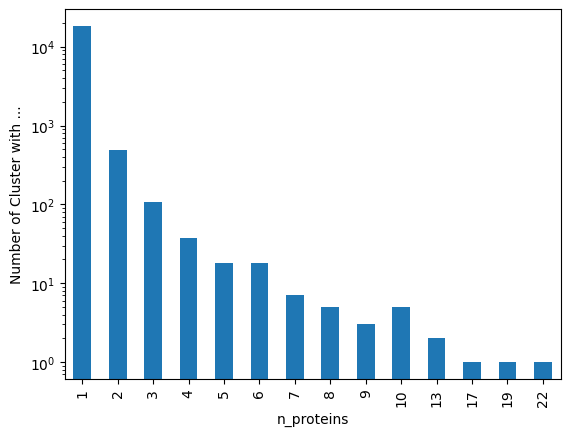

In [6]:
# create a df with clusters as entry
uniref_df = uniref_df.groupby('UniRef50_Cluster').agg({
    'protein': list,
    'gene': list, #If multiple proteins in a cluster have the same gene name, you get duplicates in the gene list
}).reset_index()

# count
uniref_df["n_proteins"] = uniref_df.protein.apply(len)
uniref_df["n_genes"] = uniref_df.gene.apply(len)
uniref_df.sort_values(by="n_proteins", inplace=True, ascending=False)

# plot
display(uniref_df)
uniref_df.n_proteins.value_counts().sort_index().plot(kind="bar", logy=True, ylabel="Number of Cluster with ...")

In [7]:
# CHECK: genes or proteins shared acorss clusters

# explode the lists into one row per (cluster, protein)
protein_cluster_map = uniref_df.explode("protein")[["UniRef50_Cluster", "protein"]].dropna()
gene_cluster_map = uniref_df.explode("gene")[["UniRef50_Cluster", "gene"]].dropna()

# group by protein and collect all clusters that contain it
protein_to_clusters = protein_cluster_map.groupby("protein")["UniRef50_Cluster"].unique()
gene_to_clusters = gene_cluster_map.groupby("gene")["UniRef50_Cluster"].unique()

# keep only proteins that occur in >1 cluster
shared_proteins = protein_to_clusters[protein_to_clusters.apply(len) > 1]
shared_genes = gene_to_clusters[gene_to_clusters.apply(len) > 1]

print(f"{len(shared_proteins)} proteins are shared between clusters")
#display(shared_proteins.head())
print(f"{len(shared_genes)} genes are shared between clusters")
#display(shared_genes.head())


0 proteins are shared between clusters
0 genes are shared between clusters


In [8]:
# Save
uniref_df.to_csv(config["data_paths"]["uniref_df_path"], index=False)